# Prelude

In [1]:
import gymnasium as gym
import torch
import numpy
import matplotlib
import math

from matplotlib import pyplot
from torch import nn, optim
from torch.nn import functional as F
from collections import deque, namedtuple
from itertools import count
from numpy import ndarray
from gymnasium import spaces
from numpy import random

from torch import optim

from torch import tensor

from IPython import display

In [2]:
import seaborn
seaborn.set()

In [3]:
device = 'cuda'

# New Skating Rink

In [4]:
from SkatingRinkEnv import SkatingRinkEnv
from DQN import DQN
from Trainer import Trainer

In [5]:
config = {
    'win_distance': 1,
    'lose_distance': 7,
    'max_eval_steps': 100,
    'hidden_size': 512,
    'lr': 0.001,
}

env = SkatingRinkEnv(config, device = 'cpu')
model = DQN(env.state_n, config['hidden_size'], env.actions_n)
model_target = DQN(env.state_n, config['hidden_size'], env.actions_n)
optimizer = optim.AdamW(model.parameters(), lr = config['lr'])

In [6]:
def circle(radius):
    circle = matplotlib.patches.Circle((0, 0), radius, color = 'black', fill = True, alpha = .1, linewidth = 2)
    pyplot.gca().add_patch(circle)

def plot_file(file, num):
    data = torch.load(file)
    config = data['config']
    env = SkatingRinkEnv(config, device = 'cpu')
    model = DQN(env.state_n, config['hidden_size'], env.actions_n)
    model.load_state_dict(data['weights'])
    model.eval()

    guys = env.dropin(num)
    states, actions, new_states, rewards, dones = [x.cpu().numpy() for x in env.eval(model, guys).tensors()]

    pyplot.rcParams['figure.figsize'] = 10, 10
    colors = seaborn.color_palette(None, num)
    times, users, dims = states.shape


    win_distance = data['config']['win_distance']
    lose_distance = data['config']['lose_distance']
    circle(win_distance)
    circle(lose_distance)
    pyplot.gca().set_aspect('equal')

    pyplot.xlim((-data['config']['lose_distance'] - 1, data['config']['lose_distance'] + 1))
    pyplot.ylim((-data['config']['lose_distance'] - 1, data['config']['lose_distance'] + 1))

    for ts in range(times):
        for p in range(users):
            marker = '' if ts != times - 1 else '*'
            pyplot.plot([states[ts,p,0], new_states[ts,p,0]], [states[ts,p,1], new_states[ts,p,1]], color = colors[p], marker = marker, alpha = 1, linewidth = 2)

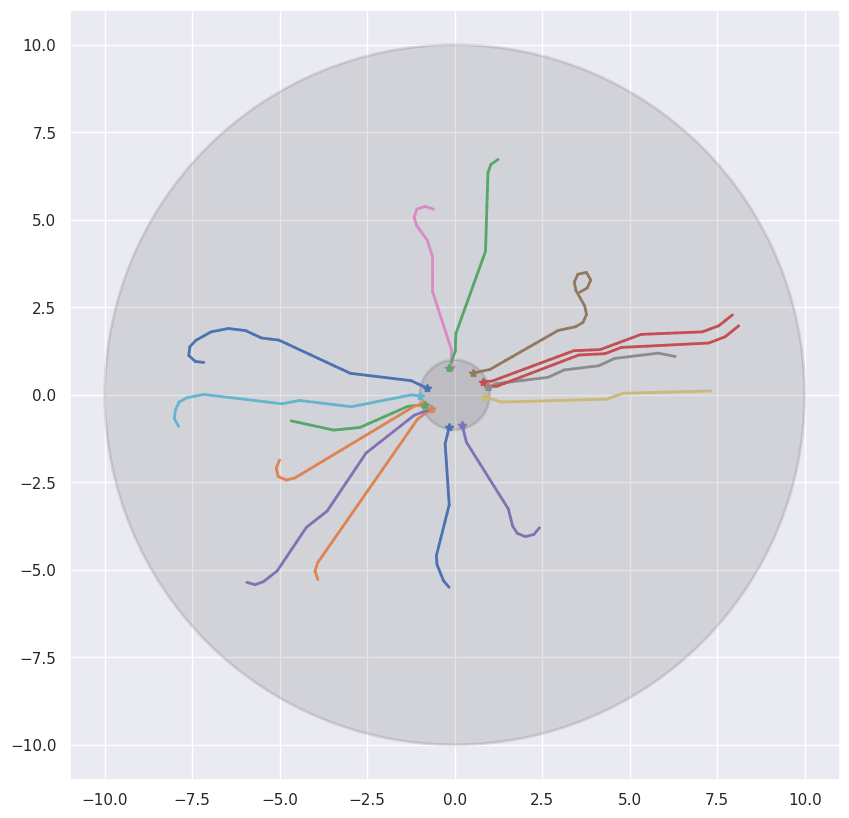

In [7]:
plot_file('ang_acc_6.pth', 15)

In [13]:
!ls dims

data26.pth  data{episode}.pth


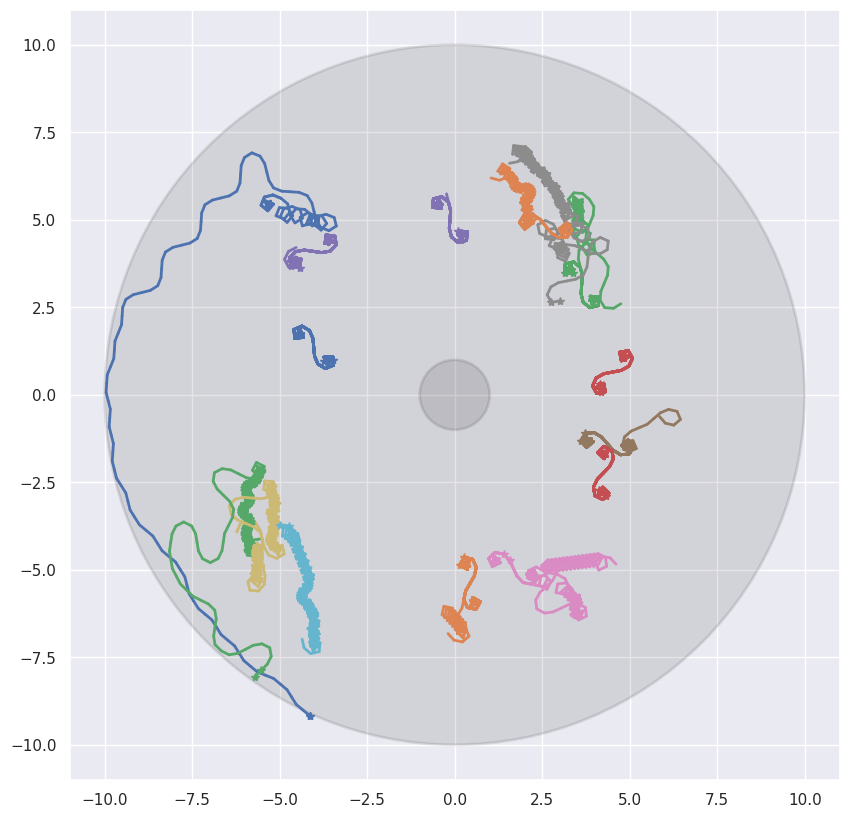

In [14]:
plot_file('dims/data26.pth', 15)

# Old Skating Rink

In [5]:
left = -1
none = 0
right = 1

speed = .1
ang_speed = 1/10 * (2 * numpy.pi)

end = numpy.array([10, 10])

class SkatingRinkEnv(gym.Env):
    state : ndarray

    def __init__(self):
        super(SkatingRinkEnv, self).__init__()
        self.action_space = spaces.Discrete(3)  # Left and right actions
        self.observation_space = spaces.Box(low=numpy.array([0, 0, -numpy.pi]), high=numpy.array([100, 100, numpy.pi]), dtype=numpy.float32)  # Example bounds

        # Initialize state
        self.state = numpy.zeros(3)

    def step(self, action : int) -> tuple[ndarray, float, bool, dict]:
        self.state = numpy.array([
            self.state[0] + action * speed * numpy.sin(self.state[2]),
            self.state[1] + action * speed * numpy.cos(self.state[2]),
            self.state[2] + ang_speed * action,
        ])

        coords = self.state[[0, 1]]
        done = numpy.sqrt(numpy.sum((coords - end) ** 2)) < 1
        reward = 1 if done else -0.01
        info = {}

        return self.state, reward, done, info

    def reset(self) -> ndarray:
        self.state = numpy.zeros(3)
        return self.state

In [6]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)  # First fully connected layer
        self.fc2 = nn.Linear(64, 64)         # Second fully connected layer
        self.fc3 = nn.Linear(64, output_dim) # Output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))  # Activation function for first layer
        x = F.relu(self.fc2(x))  # Activation function for second layer
        x = self.fc3(x)          # No activation function for output layer
        return x

In [7]:
env = SkatingRinkEnv()
model = DQN(env.observation_space.shape[0], output_dim = env.action_space.n)
target_model = DQN(env.observation_space.shape[0], output_dim = env.action_space.n)

optimizer = optim.Adam(model.parameters(), lr = .001)

d:\Users\Sean\anaconda3\envs\INM705\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from collections import deque
import random

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

In [9]:
episodes = 1  # Total episodes
gamma = 0.99  # Discount factor for future rewards
epsilon_start = 1.0  # Starting value of epsilon
epsilon_end = 0.01  # Minimum value of epsilon
epsilon_decay = 500  # Decay rate of epsilon
batch_size = 64
replay_buffer = ReplayBuffer(10000)
target_update = 10  # Update the target network every 10 episodes

# Decay function for epsilon
def epsilon_by_episode(episode):
    return epsilon_end + (epsilon_start - epsilon_end) * numpy.exp(-1. * episode / epsilon_decay)

In [11]:
# Training loop
loss_fn = torch.nn.MSELoss()
for episode in range(episodes):
    state = env.reset()
    epsilon = epsilon_by_episode(episode)
    episode_rewards = 0

    for e in range(0, 10000):
        # Epsilon-greedy action selection
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                action = model(state_tensor).argmax().item()

        # Take action and observe the next state and reward
        next_state, reward, done, _ = env.step(action)

        # Store the transition in the replay buffer
        replay_buffer.push(state, action, reward, next_state, done)

        # Move to the next state
        state = next_state
        episode_rewards += reward

        # Start learning once the replay buffer has enough samples
        if len(replay_buffer) > batch_size:
            batch = replay_buffer.sample(batch_size)
            batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = zip(*batch)

            batch_states = torch.FloatTensor(numpy.array(batch_states))
            batch_actions = torch.LongTensor(numpy.array(batch_actions))
            batch_rewards = torch.FloatTensor(numpy.array(batch_rewards))
            batch_next_states = torch.FloatTensor(numpy.array(batch_next_states))
            batch_dones = torch.FloatTensor([float(x) for x in numpy.array(batch_dones)])

            # Compute the current Q values
            current_q = model(batch_states).gather(1, batch_actions.unsqueeze(1)).squeeze(1)

            # Compute the next Q values using the target network
            next_q = model(batch_next_states).max(1)[0]
            expected_q = batch_rewards + gamma * next_q * (1 - batch_dones)

            # Compute the loss and update the network
            loss = loss_fn(current_q, expected_q.detach())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done:
            print(f"Episode: {episode}, Total Reward: {episode_rewards}")
            break
    else:
        print("Didn't get to finish!")

    # Update the target network
    if episode % target_update == 0:
        # Assuming you have a target network called target_model
        target_model.load_state_dict(model.state_dict())

Didn't get to finish!
